## Import libraries

In [1]:

from sklearn.datasets import fetch_kddcup99
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import silhouette_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
import time

## Data preprocessing

In [2]:
#Load just 10% of the full data, because it's massive around 5 millons samples
kddData = fetch_kddcup99(percent10=True)
xData = kddData.data
yData = kddData.target
print(f'Size of the input data (xData): {xData.shape}')

Size of the input data (xData): (494021, 41)


In [3]:
#Convert the data to data frame
xDf = pd.DataFrame(xData)
yDf = pd.DataFrame(yData)

In [4]:
#For replaces strings with an incrementing integer, we will use LabelEncoder of the preprocessing module
xDf = xDf.apply(pd.to_numeric, errors='ignore')#return float64 or int64 dtype depending on the data supplied
for column in xDf.columns:
    if xDf[column].dtype == object:
        xle = LabelEncoder()
        xDf[column] = xle.fit_transform(xDf[column])

#Show the new dataFrame xDf (after converting the string)
# All strings removed.
xDf.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40
0,0,1,22,9,181,5450,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,9,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0
1,0,1,22,9,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,19,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0
2,0,1,22,9,235,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,29,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0
3,0,1,22,9,219,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,39,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0
4,0,1,22,9,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,49,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0


In [ ]:
#Replaces strings with an incrementing integer in the xDf dataframe
yle = LabelEncoder()
yDf = pd.DataFrame(yle.fit_transform(yDf))


In [6]:
#Shuffle the data 
shuffledIndex = np.random.permutation(len(xDf))
xDf = xDf.iloc[shuffledIndex]
yDf = yDf.iloc[shuffledIndex]

#### Although we took just 10% of the total KDD99 dataset, it's still very large.
#### So we will take just 10000 samples 

In [7]:
#The new dataframes
nbrSamples = 10000
xDf = xDf.iloc[:nbrSamples]
yDf = yDf.iloc[:nbrSamples]

In [8]:
#Save the new dataset in a csv files for use it for Raspberry Pi
xDf.to_csv("kddData.csv", header=None, index=None)
yDf.to_csv("kddTarget.csv", header=None, index=None)

In [9]:
#Convert dataframes to arrays
#80% for training and 20% for the test
percent80 = int(nbrSamples * 0.8)
xTrain = xDf.values[:percent80]  
xTest = xDf.values[percent80:]
yTrain = yDf.values[:percent80]  
yTest = yDf.values[percent80:]


In [10]:
#Normalise the data
scaler = MinMaxScaler(feature_range=(-1,1))
xTrain = scaler.fit_transform(xTrain)
xTest = scaler.fit_transform(xTest)
xTrain

array([[-1.     , -1.     , -0.5625 , ..., -1.     , -1.     , -1.     ],
       [-1.     ,  0.     , -0.3125 , ..., -1.     , -1.     , -1.     ],
       [-1.     ,  0.     ,  0.40625, ...,  1.     , -1.     , -1.     ],
       ...,
       [-1.     , -1.     , -0.5625 , ..., -1.     , -1.     , -1.     ],
       [-1.     , -1.     , -0.5625 , ..., -1.     , -1.     , -1.     ],
       [-1.     , -1.     , -0.5625 , ..., -1.     , -1.     , -1.     ]])

In [11]:
#Tranform the type data to float16 for decrease the amount of used memory
xTrain16 = xTrain.astype(np.float16)
xTest16 = xTest.astype(np.float16)
xTrain16.shape

(8000, 41)

In [12]:
#Quantity of the data lost in the transform to float16 by calculating the variance between the columns
m = xTrain.shape[0] #number of samples
dif = (1/m)*((xTrain - xTrain16)**2)
var = dif.sum(axis=0)
maxVar = var.max()
print('The variance between the columns for the same feature :\n', var)
print('\nThe maximum variance is :', maxVar)

The variance between the columns for the same feature :
 [4.46097081e-10 0.00000000e+00 0.00000000e+00 3.13544273e-08
 9.89281515e-09 3.87819598e-09 0.00000000e+00 3.31136915e-12
 0.00000000e+00 5.83132108e-11 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.93163201e-12
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.97175595e-09 7.79064762e-09
 1.22487545e-10 3.62187624e-11 1.18207932e-10 2.38180161e-11
 3.75344548e-09 3.27925459e-09 9.88566875e-10 1.54538843e-09
 5.31006829e-09 2.72861896e-09 4.39786152e-09 9.60546173e-10
 7.09442887e-10 1.32930279e-10 9.12249088e-12 2.04745727e-10
 1.30705629e-10]

The maximum variance is : 3.135442733766074e-08


#### As you see here, the maximum variance is very low (ordre of -8), So by transforming the data format from float64 to float16 we dont lose big information of the original data

## Applying the Agglomerative clustring model

### Define the optimal number of clustres K:
we will do that by calculating the **silhouette coefficient** .

The **Silhouette Coefficient** is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b). To clarify, b is the distance between a sample and the nearest cluster that the sample is not a part of. Note that Silhouette Coefficient is only defined if number of labels is 2 <= n_labels <= n_samples - 1.

This function returns the mean Silhouette Coefficient over all samples. To obtain the values for each sample, use silhouette_samples.

The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

In [13]:
'''Calculate the silhouette coefficient for all the possible values
 of K in the range 2-> 26 for finding the optimal number of clusters 
 that correspond to the maximum silhouette coefficient '''

#List for gather the silhouette scores
silhouetteScores = []
for nbrClusters in range(2,26):
  #Applying the aglomerative clustring model
  ACModel = AgglomerativeClustering(n_clusters=nbrClusters ,affinity='euclidean')

  #Using %time for getting the training time
  yPred = ACModel.fit_predict(xTrain16)

  #Calculate the silhouette coefficient
  silhouetteScore = silhouette_score(xTrain16, yPred)

  silhouetteScores.append(silhouetteScore)


In [14]:
#The optimal number of clusters K

#The maximun Silhouette coefficient
maxScore = max(silhouetteScores)

#The index of the maximum coefficient
indexMax = silhouetteScores.index(maxScore)

#The optimal number of clusters K
K = indexMax + 2
print('The oplimal number of clusters K: ', K)

The oplimal number of clusters K:  15


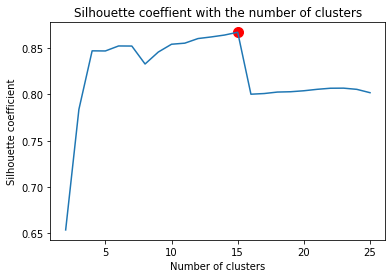

In [15]:
#plotting the silhoutte coefficient
X = range(2,26)
Y = silhouetteScores
plt.plot(X, Y)

#Show the optimal number of clusters
plt.scatter(K, Y[indexMax], c='r', s=100)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette coefficient')
plt.title('Silhouette coeffient with the number of clusters')
plt.show()

In [16]:
#Applying AC model with K cluster
ACModel = AgglomerativeClustering(n_clusters=K ,affinity='euclidean')
t0 = time.time()
yPredT = ACModel.fit_predict(xTrain16)
t1 = time.time()
t = t1 - t0
print(f'Training time for AC model with K clusters: {round(t,2)} s ' )

Training time for AC model with K clusters: 3.03 s 


## Evaluate the performance of the model

## Purity:

Purity is a measure of the extent to which clusters contain a single class.Its calculation can be thought of as follows: For each cluster, count the number of data points from the most common class in said cluster. Now take the sum over all clusters and divide by the total number of data points. Formally, given some set of clusters M and some set of classes D, both partitioning N data points, purity can be defined as:
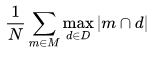

To calculate the purity, we need frist determine the confusion matrix


In [17]:
#Calculating the confusion matrix
CM = confusion_matrix(yTrain, yPred)

#To visualise the confusion matrix, convert it to a dataframe
#print('The confusion matrix :')
pd.DataFrame(CM)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,25,0,0,0,0,0,7,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,20,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,815,0,0,0,0,0,583,0,0,0,351,0,0,0,0,0,0,0,0,0,0,0


In [18]:
#Calculating the  purity
purity = (CM.max(axis=1).sum())/len(yTrain)
print(f'The train purity of the model is: {round(purity*100, 2)} %')

The train purity of the model is: 73.98 %


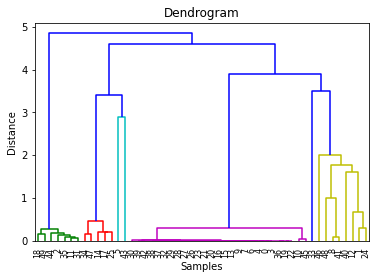

In [21]:
#Draw the hierarchical graph (Dendrogram)
dendograme = sch.dendrogram(sch.linkage(xTrain16[:50]))
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.title('Dendrogram')
plt.show()